In [ ]:
# imports
import pandas as pd
import os

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random 
import numpy as np 

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import datetime
from datetime import timedelta

import polars as pl
import glob
import seaborn as sns

import data_preprocessing

In [ ]:
# read the integrated raw main databases from: https://openhsu.ub.hsu-hh.de/handle/10.24405/20048
csv_files_maindatabase = sorted(glob.glob(os.path.join('DiaData/datasets for T1D/maindatabase', '*.csv')))
combined_main_raw = pd.concat([pl.read_csv(file).to_pandas() for file in csv_files_maindatabase], ignore_index=True)
# converts the timestamp column to datetime
combined_main_raw["ts"] = pd.to_datetime(combined_main_raw["ts"])

## Assign classes and generate time series

In [ ]:
# dataset with interpolated values is copied
classes_df = combined_main_raw.copy()
# initially all classes are assigned a class -1
classes_df["Class"] = -1
# hypoglycemic values are defined as class 0 with values equal and lower than 70 mg/dL
classes_df.loc[classes_df["GlucoseCGM"] <= 70, "Class"] = 0

# calls the function class_generation to assing classes based on wanted intervals before hypogylcemia for each subject separately
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 5, 15, 1)) # 5-15 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 15, 30, 2)) # 15-30 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 30, 60, 3))  # 30-60 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts",  60, 125, 4)) # 1-2 h
classes_df.loc[classes_df["Class"] == -1, "Class"] = 5

# sorts the glucose values by patient id and timestamps
df_sorted = classes_df.sort_values(by=['PtID', 'ts'])
# reindexes based on the sorted dataset
df_sorted = df_sorted.reset_index(drop=True)

In [ ]:
classes_df["Class"].value_counts()

Class
5    239055257
4      7045918
0      6572292
3      3577883
2      1941618
1      1548177
Name: count, dtype: int64

## Normalization

In [ ]:
# normalizes data 
df_min_max_scaled = data_preprocessing.normalize_data(df_sorted, 'GlucoseCGM')

## Genearte time series 

In [ ]:
# generates time series with sliding window approach
result = df_min_max_scaled.groupby('PtID').apply(lambda g: data_preprocessing.extract_valid_windows_GLC(g))

# filters out None values of subjects with insufficient data
filtered_result = [item for item in result if item is not None]
# unpacks the values
X_train, X_val, X_test, Y_train, Y_val, Y_test = zip(*filtered_result)

In [17]:
len(X_train)

2248

In [ ]:
# data are flattened to match the required shape
X_train = data_preprocessing.flatten_data(X_train, modus = "input", dim = 1)
X_val = data_preprocessing.flatten_data(X_val, modus = "input", dim = 1)
X_test = data_preprocessing.flatten_data(X_test, modus = "input", dim = 1)

(8097735, 25, 1)
(1737006, 25, 1)
(1736822, 25, 1)


In [ ]:
# data are flattened to match the required shape
Y_train = data_preprocessing.flatten_data(Y_train, modus = "output", dim = 1)
Y_val = data_preprocessing.flatten_data(Y_val, modus = "output", dim = 1)
Y_test = data_preprocessing.flatten_data(Y_test, modus = "output", dim = 1)

(8097735, 1)
(1737006, 1)
(1736822, 1)


In [21]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2857148,  510579,  730088, 1367337, 2632583]))

In [22]:
np.unique(Y_val, return_counts=True)

(array([0, 1, 2, 3, 4]), array([592750, 110406, 159113, 299344, 575393]))

In [23]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([579247, 111804, 161229, 303370, 581172]))

## Class undersampling

In [ ]:
def undersampling(X, y):
    # flattens y if it's 2D
    if isinstance(y, np.ndarray) and y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    # reshapes X for sampling
    num_samples, window_size, _ = X.shape
    X_reshaped = X.reshape(num_samples, window_size)

    # creates a balanced strategy
    from collections import Counter
    min_class_count = min(Counter(y).values())
    sampling_strategy = {int(cls): min_class_count for cls in np.unique(y)}

    # applies undersampling
    from imblearn.under_sampling import RandomUnderSampler
    undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_under, y_under = undersample.fit_resample(X_reshaped, y)

    # reshapes back to 3D
    X_under = X_under.reshape(-1, window_size, 1)
    y_under = y_under.reshape(-1, 1)

    return X_under, y_under

In [25]:
X_train, Y_train = undersampling(X_train, Y_train)
X_val, Y_val = undersampling(X_val, Y_val)
X_test, Y_test = undersampling(X_test, Y_test)

## ResNet Model

2025-05-28 11:35:41.468788: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-28 11:35:41.473808: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-28 11:35:41.473819: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-28 11:35:41.473857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-28 11:35:41.473879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-28 11:35:41.545675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Yo

Epoch 1/50


2025-05-28 11:35:43.031491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-28 11:40:18.705901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.68606, saving model to CustomModel.weights.hdf5
9973/9973 - 297s - loss: 0.7387 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.7034 - lr: 1.0000e-04 - 297s/epoch - 30ms/step
Epoch 2/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.68606 to 0.68165, saving model to CustomModel.weights.hdf5
9973/9973 - 378s - loss: 0.6961 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.6817 - val_sparse_categorical_accuracy: 0.6999 - lr: 1.0000e-04 - 378s/epoch - 38ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.68165 to 0.66960, saving model to CustomModel.weights.hdf5
9973/9973 - 297s - loss: 0.6861 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.6696 - val_sparse_categorical_accuracy: 0.7103 - lr: 1.0000e-04 - 297s/epoch - 30ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.66960 to 0.66795, saving model to CustomModel.weights.hdf5
9973/9973 - 277s - loss: 0.6806 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.7076 - lr: 1.0000e-04 - 277s/epoch - 28ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.66795 to 0.66365, saving model to CustomModel.weights.hdf5
9973/9973 - 278s - loss: 0.6759 - sparse_categorical_accuracy: 0.7056 - 

2025-05-28 13:18:36.968783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17470/17470 [==============================] - 83s 5ms/step


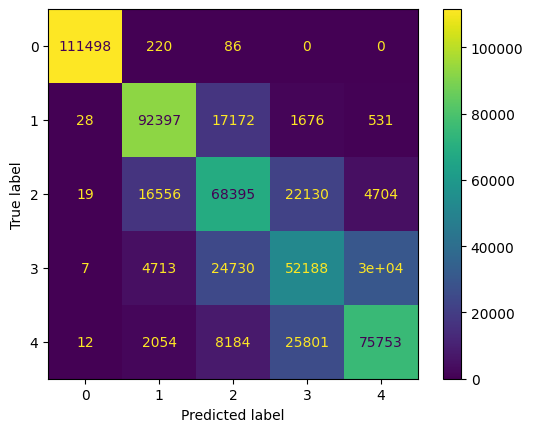

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111804
           1       0.80      0.83      0.81    111804
           2       0.58      0.61      0.59    111804
           3       0.51      0.47      0.49    111804
           4       0.68      0.68      0.68    111804

    accuracy                           0.72    559020
   macro avg       0.71      0.72      0.71    559020
weighted avg       0.71      0.72      0.71    559020



In [ ]:
# source: https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/ResNet.py
# 2DCNN layers were replaced with 1DCNN layers and He normal kernel initilization was included

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# 
# #!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 01:09:17 2016

@author: stephen
"""

from tensorflow import keras
import numpy as np
import pandas as pd

seed_value= 42  
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



def build_resnet_1d(input_shape, n_feature_maps, nb_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = BatchNormalization()(inputs)
    x = Conv1D(n_feature_maps, 8, padding='same',kernel_initializer='he_normal' )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps, 1, padding='same',kernel_initializer='he_normal')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 2
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 3
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    output = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    return model




# Define the early stopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)

# initialize callbacks 
reduceLR =ReduceLROnPlateau(monitor='val_loss', patience=3, verbose= 1, mode='min', factor= 0.2, min_lr = 1e-5) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min') 

callbacks= [early_stopping, checkpoint, reduceLR]

BUFFER_SIZE = len(X_train) #100_000
BATCH_SIZE = 256

Y_train_rs = Y_train.reshape(-1).astype('int32')
Y_val_rs = Y_val.reshape(-1).astype('int32')
Y_test_rs = Y_test.reshape(-1).astype('int32')

X_train_t = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_t = tf.convert_to_tensor(Y_train_rs, dtype=tf.int32)

X_val_t = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val_t = tf.convert_to_tensor(Y_val_rs, dtype=tf.int32)

X_test_t = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_t = tf.convert_to_tensor(Y_test_rs, dtype=tf.int32)

train_ds_t = tf.data.Dataset.from_tensor_slices((X_train_t, Y_train_t))
train_ds = train_ds_t.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_t, Y_val_t)).batch(BATCH_SIZE)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# Build and train model
model_wang_resnet2 = build_resnet_1d((X_train.shape[1], X_train.shape[2]), 64, 5) 
model_wang_resnet2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])
model_wang_resnet2.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks, verbose=2)


# Evaluation of the model and Confusion Matrix
model_wang_resnet2.evaluate(X_test_t, Y_test_t)
predictions_model_wang_resnet2 = model_wang_resnet2.predict(X_test_t)
y_pred_model_wang_resnet2 = np.argmax(predictions_model_wang_resnet2, axis=1) 
ConfusionMatrixDisplay.from_predictions(
    Y_test_t, y_pred_model_wang_resnet2)
plt.show()

print(classification_report(Y_test_t, y_pred_model_wang_resnet2))

model_wang_resnet2.save("model_wang_resnet_MDB_raw.keras")